#Group 1
Fabio Ceruti - Fabio Martino - Alex Lucchini - Jacopo Biggiogera

In this notebook, the distribution of the context average colors of each family and species is obtained, to identify potential differences among the classes, which may explain where context could be more powerful for identification purposes.

In [1]:
import pandas as pd 
import numpy as np 
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from collections import defaultdict
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.image import resize_with_pad, ResizeMethod
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from random import shuffle
from tensorflow.keras import models
from tensorflow.keras import optimizers
from tqdm import tqdm
from tensorflow.keras.layers.experimental.preprocessing import Rescaling

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Data Loading and Average Context (Train/Val)

In this section, the train/val dataset is loaded, and the average context color of each image is computed.

In [ ]:
train_val = pd.read_csv('/content/drive/MyDrive/correct_bboxes.csv').drop('Unnamed: 0', axis = 1)

for i in range(len(train_val['pic_name'])): 
  train_val.loc[i, 'path_name'] = '/content/drive/MyDrive/Contexts/' + train_val.loc[i, 'pic_name']

In [ ]:
#Generation of families labels
reptilia = ['Anolis carolinensis', 'Chelydra serpentina', 'Trachemys scripta elegans']
mammalia = ['Canis latrans', 'Procyon lotor', 'Sciurus carolinensis']
aves = ['Pandion haliaetus', 'Picoides pubescens', 'Spinus tristis']
insecta = ['Harmonia axyridis', 'Junonia coenia', 'Pachydiplax longipennis']
species = reptilia + mammalia + aves + insecta

family = dict()
for i in range(len(species)):
  if species[i] in reptilia:
    family[species[i]] = 'reptilia'
  elif species[i] in mammalia:
    family[species[i]] = 'mammalia'
  elif species[i] in aves:
    family[species[i]] = 'aves'
  elif species[i] in insecta:
    family[species[i]] = 'insecta'

for i in range(len(train_val['path_name'])):
  train_val.loc[i, 'family'] = family[train_val.loc[i, 'species']]

train_val.loc[train_val['family'] == 'mammalia', 'family_label'] = 0
train_val.loc[train_val['family'] == 'aves', 'family_label'] = 1
train_val.loc[train_val['family'] == 'reptilia', 'family_label'] = 2
train_val.loc[train_val['family'] == 'insecta', 'family_label'] = 3

This function computes the average value of each channel of the image, considering only positive values, and thus ignoring the "0" pixels, corresponding to the black masks. In this way, it's possible to obtain the average context color of each channel.

In [ ]:
def averages(image):
  if len(image.shape) == 2:
    average = image.mean()
    return average, None, None
  else:
    average_0 = image[:,:,0][image[:,:,0] != 0].mean()
    average_1 = image[:,:,1][image[:,:,1] != 0].mean()
    average_2 = image[:,:,2][image[:,:,2] != 0].mean()
    return average_0, average_1, average_2

In [ ]:
for i in tqdm(range(len(train_val['path_name']))):
  train_val.loc[i, 'average_0'] = averages(np.array(PIL.Image.open(train_val.loc[i, 'path_name'])))[0]
  train_val.loc[i, 'average_1'] = averages(np.array(PIL.Image.open(train_val.loc[i, 'path_name'])))[1]
  train_val.loc[i, 'average_2'] = averages(np.array(PIL.Image.open(train_val.loc[i, 'path_name'])))[2]

100%|██████████| 13298/13298 [54:41<00:00,  4.05it/s]


In [ ]:
train_val.to_csv('/content/drive/MyDrive/avg_colors.csv')

#Context Colors Distributions (Train/Val)

In this section, the distribution of the context color is plotted for each species and family. The train/val images have been chosen since they allow for more representative and accurate distributions, given their large number.

In [3]:
train_val = pd.read_csv('/content/drive/MyDrive/avg_colors.csv')
train_val.head()

,Unnamed: 0,pic_name,bbox,id,path_name,species,family,family_label,average_0,average_1,average_2
0,0,24a78d176d2408fae40725cdc48bd605.jpg,"[[281, 225, 118, 125]]",159413,/content/drive/MyDrive/Contexts/24a78d176d2408...,Pandion haliaetus,aves,1.0,146.786255,147.679594,136.808947
1,1,8f87370536337294de8c925c3668ae2d.jpg,"[[234, 168, 337, 196]]",77529,/content/drive/MyDrive/Contexts/8f873705363372...,Pachydiplax longipennis,insecta,3.0,92.162132,87.914833,43.620109
2,2,5d85146f3c7c25f71ca15ec9b4d8be54.jpg,"[[132, 110, 497, 520]]",275890,/content/drive/MyDrive/Contexts/5d85146f3c7c25...,Junonia coenia,insecta,3.0,136.246966,122.692957,87.780958
3,3,70958a293b1b2897248604c57fed16fb.jpg,"[[324, 310, 175, 160]]",2786,/content/drive/MyDrive/Contexts/70958a293b1b28...,Picoides pubescens,aves,1.0,93.908217,111.630285,134.805184
4,4,572b82540fca7c20c6246b0bd602c2f0.jpg,"[[247, 29, 295, 268]]",309373,/content/drive/MyDrive/Contexts/572b82540fca7c...,Harmonia axyridis,insecta,3.0,178.199313,173.546194,176.321815


In [4]:
#Generation of families
reptilia = ['Anolis carolinensis', 'Chelydra serpentina', 'Trachemys scripta elegans']
mammalia = ['Canis latrans', 'Procyon lotor', 'Sciurus carolinensis']
aves = ['Pandion haliaetus', 'Picoides pubescens', 'Spinus tristis']
insecta = ['Harmonia axyridis', 'Junonia coenia', 'Pachydiplax longipennis']
species = reptilia + mammalia + aves + insecta

family = dict()
for i in range(len(species)):
  if species[i] in reptilia:
    family[species[i]] = 'reptilia'
  elif species[i] in mammalia:
    family[species[i]] = 'mammalia'
  elif species[i] in aves:
    family[species[i]] = 'aves'
  elif species[i] in insecta:
    family[species[i]] = 'insecta'

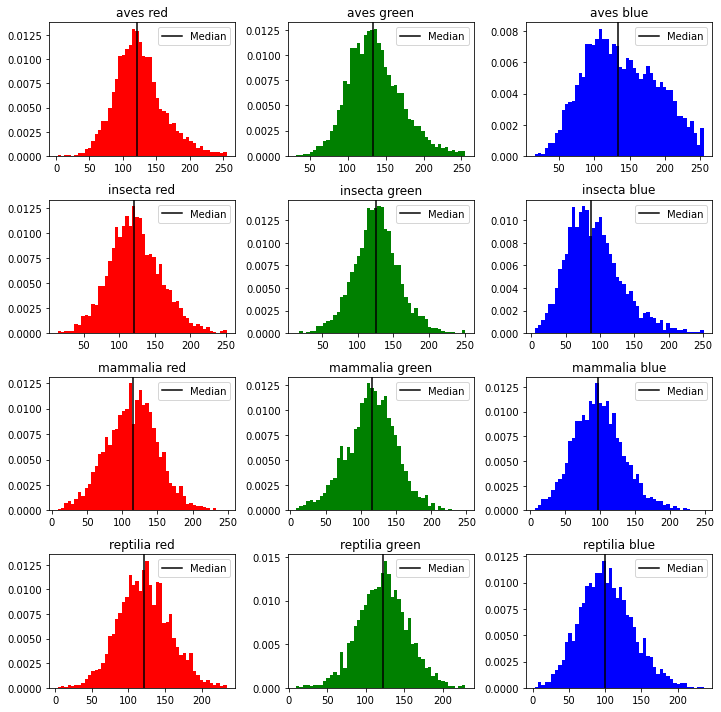

In [7]:
#Distribution of the average context color for each family
families = ['aves', 'insecta', 'mammalia', 'reptilia']
colors = ['red', 'green', 'blue']
fig, axs = plt.subplots(4,3, figsize = (10,10))
for i in range(4):
  family = families[i]
  for j in range(3):
    axs[i,j].set_title(family + ' ' + colors[j])
    axs[i,j].hist(train_val.loc[train_val['family'] == family, f'average_{j}'], bins = 50, density = True, color = f'{colors[j]}') #label = family + ' ' + colors[j]
    axs[i,j].axvline(train_val.loc[train_val['family'] == family, f'average_{j}'].median(), label = 'Median', color = 'black')
    axs[i,j].legend()
plt.tight_layout()
plt.show()

As it's possible to see, for both the red and the green channel, there are no striking differences in terms of the context color distributions. However, the distribution of the blue channel for "aves" is more skewed to the right, while the one for "insecta" is slighlty more skewed to the left. Intuitively, this is due to the prevalence of the sky as a context in the "aves" family, while, for "insecta", the ground is more likely to be the dominating context. 
Such difference in the blue channel is identifiabile also in the following plot, where the distributions of the same channel are plotted in the same graph across the four families.

<ipython-input-38-6b3b6d191391>:7: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,3,j+1).set_title(colors[j])


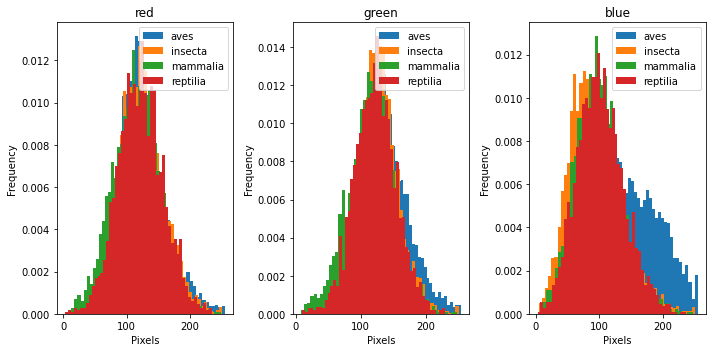

In [ ]:
plt.figure(figsize=(10, 5))
families = ['aves', 'insecta', 'mammalia', 'reptilia']
colors = ['red', 'green', 'blue']
for i in range(4):
  family = families[i]
  for j in range(3):
    plt.subplot(1,3,j+1).set_title(colors[j])
    plt.hist(train_val.loc[train_val['family'] == family, f'average_{j}'], bins = 50, label = family, density = True)
    plt.legend()
    plt.xlabel('Pixels')
    plt.ylabel('Frequency')
#plt.subplot_tool()
plt.tight_layout()
plt.show()

In the graphs belows, the distribution of the average context color is plotted for each channel for each species.

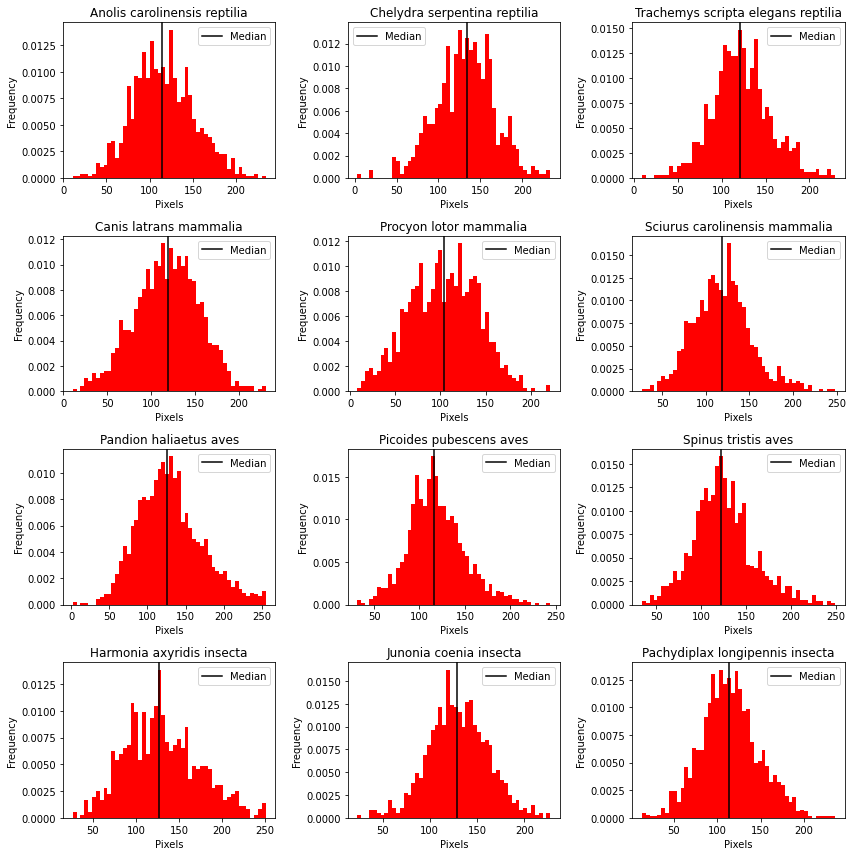

In [ ]:
#Per species distributions of the red channel
plt.figure(figsize = (12,12))
for i in range(len(species)):
  specie = species[i]
  plt.subplot(4,3,i+1).set_title(specie + ' ' + family[specie])
  plt.hist(train_val.loc[(train_val['family'] == family[specie]) & (train_val['species'] == specie), 'average_0'], bins = 50, density = True, color = 'red')
  plt.axvline(train_val.loc[(train_val['family'] == family[specie]) & (train_val['species'] == specie), 'average_0'].median(), label = 'Median', color = 'black')
  plt.legend()
  plt.xlabel('Pixels')
  plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

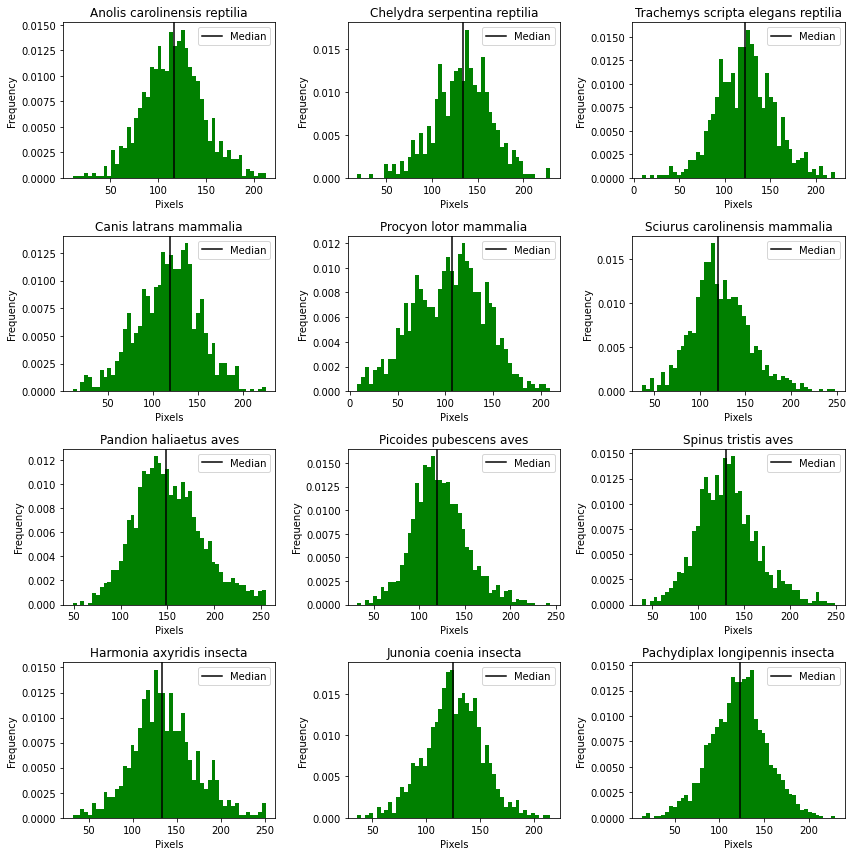

In [ ]:
#Per species distributions of the green channel
plt.figure(figsize = (12,12))
for i in range(len(species)):
  specie = species[i]
  plt.subplot(4,3,i+1).set_title(specie + ' ' + family[specie])
  plt.hist(train_val.loc[(train_val['family'] == family[specie]) & (train_val['species'] == specie), 'average_1'], bins = 50, color = 'green', density = True)
  plt.axvline(train_val.loc[(train_val['family'] == family[specie]) & (train_val['species'] == specie), 'average_1'].median(), label = 'Median', color = 'black')
  plt.legend()
  plt.xlabel('Pixels')
  plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

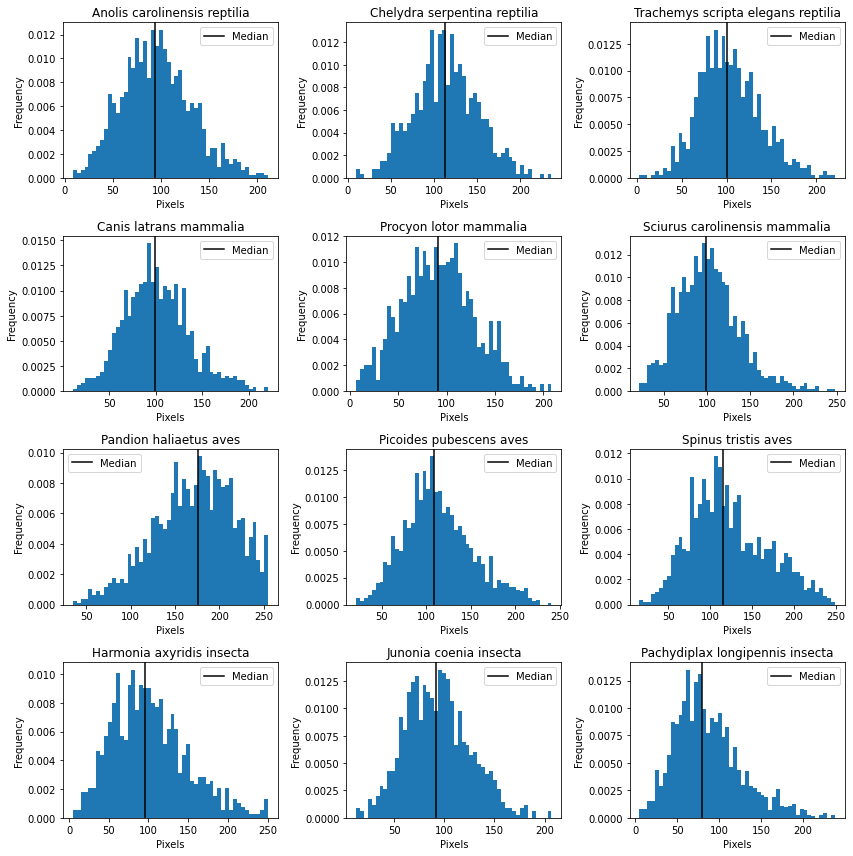

In [ ]:
#Per species distributions of the blue channel
plt.figure(figsize = (12,12))
for i in range(len(species)):
  specie = species[i]
  plt.subplot(4,3,i+1).set_title(specie + ' ' + family[specie])
  plt.hist(train_val.loc[(train_val['family'] == family[specie]) & (train_val['species'] == specie), 'average_2'], bins = 50, density = True)
  plt.axvline(train_val.loc[(train_val['family'] == family[specie]) & (train_val['species'] == specie), 'average_2'].median(), label = 'Median', color = 'black')
  plt.legend()
  plt.xlabel('Pixels')
  plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

While both the red and the green channel seemingly do not provide any additional information, the analysis of the per species blue channel distributions allows to identify the species "Pandion haliaetus" as the one characterized by a skewed distribution to the right, and thus driving the skeweness of the blue channel distribution of the "aves" family. Therefore, context is expected to be more powerful for the identification of such species.

In [ ]:
#This function fills the black mask with the average color of the context.
def avg_filling(img):
  image = img.copy()
  average_0 = image[:,:,0][image[:,:,0] != 0].mean()
  average_1 = image[:,:,1][image[:,:,1] != 0].mean()
  average_2 = image[:,:,2][image[:,:,2] != 0].mean()
  image[:,:,0][image[:,:,0] == 0] = average_0
  image[:,:,1][image[:,:,1] == 0] = average_1
  image[:,:,2][image[:,:,2] == 0] = average_2
  return image

#Context Color Distribution (Test)

This section repeats the same previous steps in this notebook for the test images. This is done to then obtain additional features which are to be used in the error analysis.

In [ ]:
#Import of the data
import pickle
with open('/content/drive/MyDrive/transfer_mixed_testresults.pickle', "rb") as f:
    mixed = pickle.load(f)
with open('/content/drive/MyDrive/transfer_masked_testresults.pickle', "rb") as f:
    masked = pickle.load(f)
with open('/content/drive/MyDrive/transfer_bbcontent_testresults.pickle', "rb") as f:
    bb_content = pickle.load(f)
with open('/content/drive/MyDrive/transfer_vanilla_testresults.pickle', "rb") as f:
    vanilla = pickle.load(f)

In [ ]:
logit = pd.read_csv('/content/drive/MyDrive/logit_final.csv').drop(['Unnamed: 0', 'saturation'], axis = 1)
print(logit.shape)
logit.head()

(2564, 13)


,misscl_masked,sift,contrast,bright,species,path,misscl_vanilla,misscl_bbcontent,misscl_mixed,family,red,green,blue
0,0,156,44.678057,122.619973,Pandion haliaetus,Animals/Pandion haliaetus/fdd144a72e5da77cff15...,0,0,0,aves,75.529122,11.546985,28.336603
1,1,2784,76.915200,80.271130,Spinus tristis,Animals/Spinus tristis/e9c56231718b9b11758f5f9...,0,0,0,aves,11.764276,0.255391,0.093554
2,0,330,96.223408,195.855005,Pachydiplax longipennis,Animals/Pachydiplax longipennis/c67ae3e186acb3...,0,0,0,insecta,50.937013,12.645696,16.546658
3,1,1671,92.882461,46.955006,Canis latrans,Animals/Canis latrans/0a922be91bac509ef2bc0a44...,1,1,1,mammalia,32.302684,5.813796,10.957970
4,1,3032,84.739734,85.638236,Trachemys scripta elegans,Animals/Trachemys scripta elegans/fa1dd0961941...,0,1,1,reptilia,9.112623,1.590392,14.203597


In [ ]:
logit['misscl_masked'] = 1 - logit['misscl_masked']
logit['misscl_vanilla'] = 1 - logit['misscl_vanilla']
logit['misscl_mixed'] = 1 - logit['misscl_mixed']
logit['misscl_bbcontent'] = 1 - logit['misscl_bbcontent']

In [ ]:
logit = logit.rename({'misscl_masked':'masked', 'misscl_vanilla':'vanilla', 'misscl_mixed':'mixed', 'misscl_bbcontent':'bbcontent'}, axis = 1)
logit.head()

,masked,sift,contrast,bright,species,path,vanilla,bbcontent,mixed,family,red,green,blue
0,1,156,44.678057,122.619973,Pandion haliaetus,Animals/Pandion haliaetus/fdd144a72e5da77cff15...,1,1,1,aves,75.529122,11.546985,28.336603
1,0,2784,76.915200,80.271130,Spinus tristis,Animals/Spinus tristis/e9c56231718b9b11758f5f9...,1,1,1,aves,11.764276,0.255391,0.093554
2,1,330,96.223408,195.855005,Pachydiplax longipennis,Animals/Pachydiplax longipennis/c67ae3e186acb3...,1,1,1,insecta,50.937013,12.645696,16.546658
3,0,1671,92.882461,46.955006,Canis latrans,Animals/Canis latrans/0a922be91bac509ef2bc0a44...,0,0,0,mammalia,32.302684,5.813796,10.957970
4,0,3032,84.739734,85.638236,Trachemys scripta elegans,Animals/Trachemys scripta elegans/fa1dd0961941...,1,0,0,reptilia,9.112623,1.590392,14.203597


In [ ]:
logit.to_csv('/content/drive/MyDrive/final_logit.csv')

In [ ]:
test = pd.read_csv('/content/drive/MyDrive/final_logit.csv').drop('Unnamed: 0', axis = 1)
for i in range(len(test['path'])):
  test.loc[i, 'path'] = '/content/drive/MyDrive/Animals_masked/Animals_masked' + test.loc[i, 'path'][7:]
test.head()

,masked,sift,contrast,bright,species,path,vanilla,bbcontent,mixed,family,red,green,blue
0,1,156,44.678057,122.619973,Pandion haliaetus,/content/drive/MyDrive/Animals_masked/Animals_...,1,1,1,aves,75.529122,11.546985,28.336603
1,0,2784,76.915200,80.271130,Spinus tristis,/content/drive/MyDrive/Animals_masked/Animals_...,1,1,1,aves,11.764276,0.255391,0.093554
2,1,330,96.223408,195.855005,Pachydiplax longipennis,/content/drive/MyDrive/Animals_masked/Animals_...,1,1,1,insecta,50.937013,12.645696,16.546658
3,0,1671,92.882461,46.955006,Canis latrans,/content/drive/MyDrive/Animals_masked/Animals_...,0,0,0,mammalia,32.302684,5.813796,10.957970
4,0,3032,84.739734,85.638236,Trachemys scripta elegans,/content/drive/MyDrive/Animals_masked/Animals_...,1,0,0,reptilia,9.112623,1.590392,14.203597


In [ ]:
#Computation of the average context color of each channel of test images
for i in range(len(test['path'])):
  if test.loc[i,'path'][-7:-4] == '(1)' or test.loc[i,'path'][-7:-4] == '(2)' or test.loc[i,'path'][-7:-4] == '(3)':
    test.loc[i, 'path'] = test.loc[i, 'path'][:-7] + test.loc[i, 'path'][-4:]

for i in tqdm(range(len(test['path']))):
  try:
    test.loc[i, 'average_0'] = averages(np.array(PIL.Image.open(test.loc[i, 'path'])))[0]
    test.loc[i, 'average_1'] = averages(np.array(PIL.Image.open(test.loc[i, 'path'])))[1]
    test.loc[i, 'average_2'] = averages(np.array(PIL.Image.open(test.loc[i, 'path'])))[2]
  except:
    test.loc[i, 'average_0'] = None
    test.loc[i, 'average_1'] = None
    test.loc[i, 'average_2'] = None

test.to_csv('/content/drive/MyDrive/final_logit.csv')

100%|██████████| 2564/2564 [09:21<00:00,  4.57it/s]


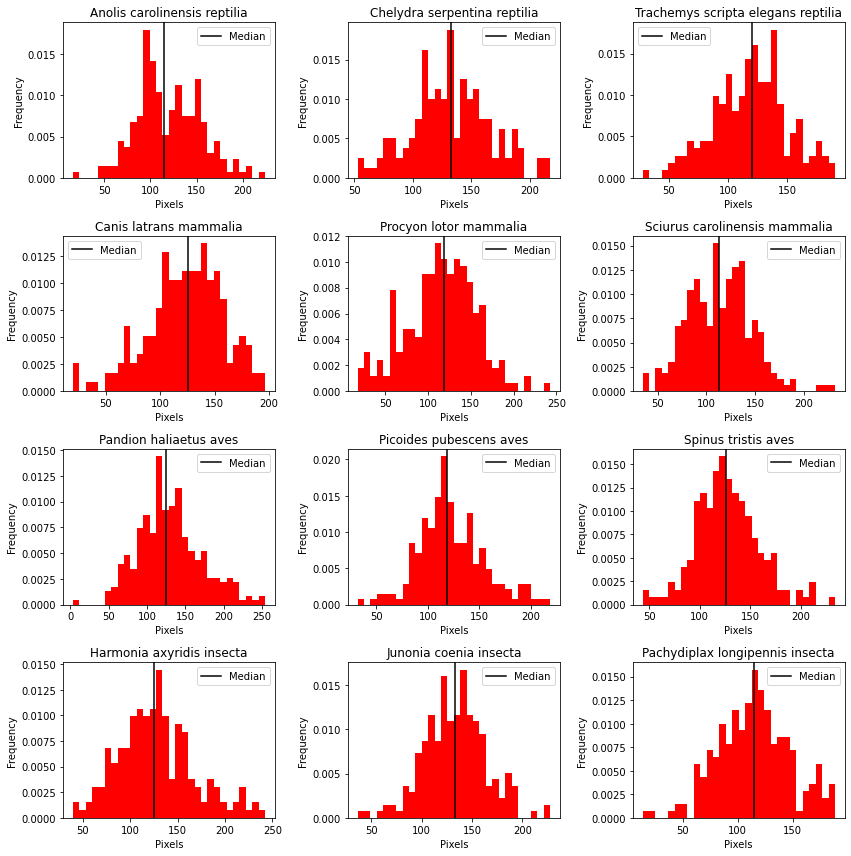

In [ ]:
#Per species context color distribution of the red channel
plt.figure(figsize = (12,12))
for i in range(len(species)):
  specie = species[i]
  plt.subplot(4,3,i+1).set_title(specie + ' ' + family[specie])
  plt.hist(test.loc[(test['family'] == family[specie]) & (test['species'] == specie), 'average_0'], bins = 30, density = True, color = 'red')
  plt.axvline(test.loc[(test['family'] == family[specie]) & (test['species'] == specie), 'average_0'].median(), label = 'Median', color = 'black')
  plt.legend()
  plt.xlabel('Pixels')
  plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

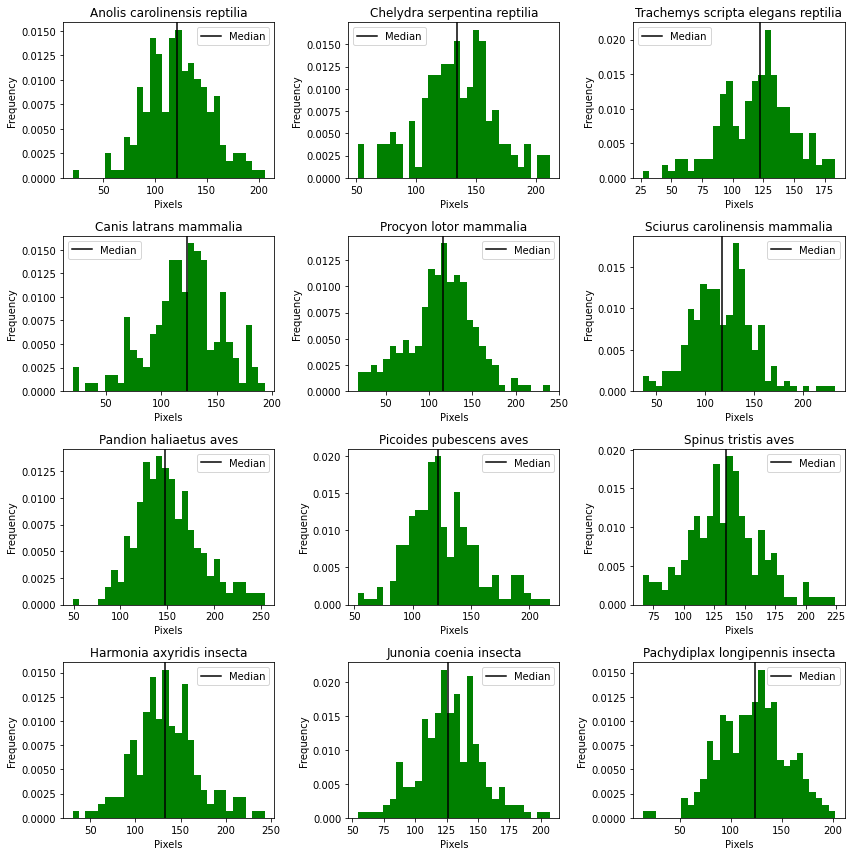

In [ ]:
#Per species context color distribution of the green channel
plt.figure(figsize = (12,12))
for i in range(len(species)):
  specie = species[i]
  plt.subplot(4,3,i+1).set_title(specie + ' ' + family[specie])
  plt.hist(test.loc[(test['family'] == family[specie]) & (test['species'] == specie), 'average_1'], bins = 30, density = True, color = 'green')
  plt.axvline(test.loc[(test['family'] == family[specie]) & (test['species'] == specie), 'average_1'].median(), label = 'Median', color = 'black')
  plt.legend()
  plt.xlabel('Pixels')
  plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

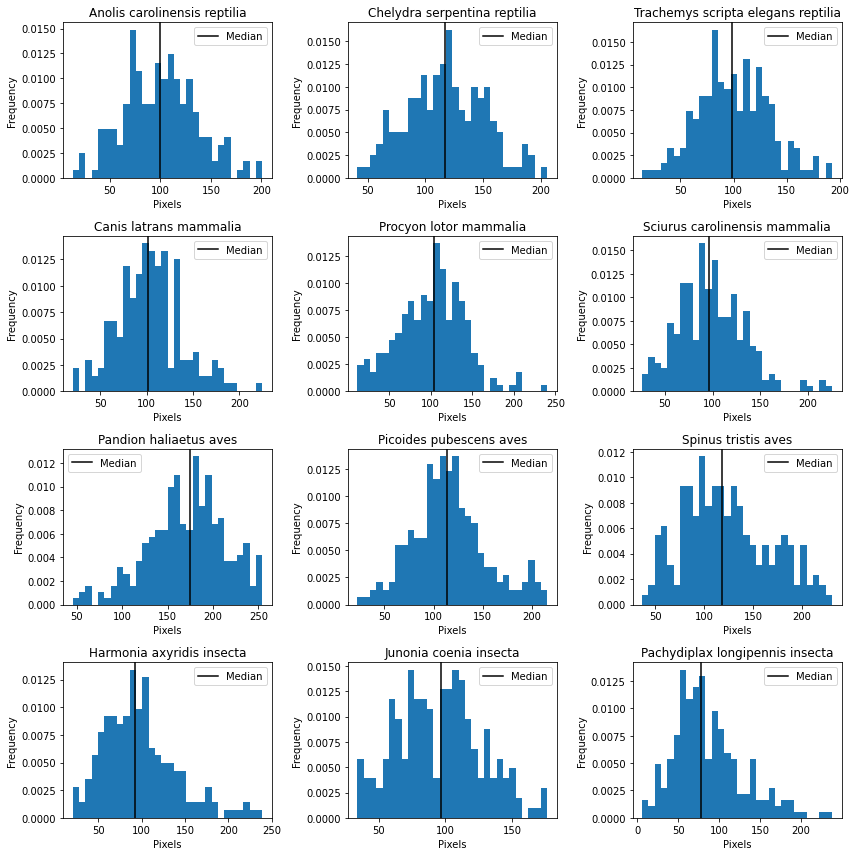

In [ ]:
#Per species context color distribution of the blue channel
plt.figure(figsize = (12,12))
for i in range(len(species)):
  specie = species[i]
  plt.subplot(4,3,i+1).set_title(specie + ' ' + family[specie])
  plt.hist(test.loc[(test['family'] == family[specie]) & (test['species'] == specie), 'average_2'], bins = 30, density = True)
  plt.axvline(test.loc[(test['family'] == family[specie]) & (test['species'] == specie), 'average_2'].median(), label = 'Median', color = 'black')
  plt.legend()
  plt.xlabel('Pixels')
  plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

As it's possible to see, the distributions above are consistent with the ones obtained from the train/val set, thus the conclusions are analogous.
In the cells below, for each image (and for each channel), the difference between its context color and the median context color of all the images is computed. This provides a measure of how "extreme" an image is with respect to the others, when it comes its context color.

In [ ]:
for i in range(len(test['path'])):
  test.loc[i, 'diff_cont_red'] = test.loc[i, 'average_0'] - test.loc[:, 'average_0'].median()
  test.loc[i, 'diff_cont_green'] = test.loc[i, 'average_1'] - test.loc[:, 'average_1'].median()
  test.loc[i, 'diff_cont_blue'] = test.loc[i, 'average_2'] - test.loc[:, 'average_2'].median()

In [ ]:
test.loc[:, 'diff_cont_red'] = test.loc[:, 'average_0'] - test.loc[:, 'average_0'].median()
test.loc[:, 'diff_cont_green'] = test.loc[:, 'average_1'] - test.loc[:, 'average_1'].median()
test.loc[:, 'diff_cont_blue'] = test.loc[:, 'average_2'] - test.loc[:, 'average_2'].median()

In [ ]:
test.head()

,masked,sift,contrast,bright,species,path,vanilla,bbcontent,mixed,family,red,green,blue,average_0,average_1,average_2,diff_cont_red,diff_cont_green,diff_cont_blue
0,1,156,44.678057,122.619973,Pandion haliaetus,/content/drive/MyDrive/Animals_masked/Animals_...,1,1,1,aves,75.529122,11.546985,28.336603,96.900701,142.450679,192.453651,-25.216641,15.383413,86.988780
1,0,2784,76.915200,80.271130,Spinus tristis,/content/drive/MyDrive/Animals_masked/Animals_...,1,1,1,aves,11.764276,0.255391,0.093554,123.198697,126.486752,101.010407,1.081354,-0.580514,-4.454465
2,1,330,96.223408,195.855005,Pachydiplax longipennis,/content/drive/MyDrive/Animals_masked/Animals_...,1,1,1,insecta,50.937013,12.645696,16.546658,103.198176,109.649786,70.611125,-18.919167,-17.417480,-34.853747
3,0,1671,92.882461,46.955006,Canis latrans,/content/drive/MyDrive/Animals_masked/Animals_...,0,0,0,mammalia,32.302684,5.813796,10.957970,134.831277,132.248096,141.998666,12.713934,5.180830,36.533795
4,0,3032,84.739734,85.638236,Trachemys scripta elegans,/content/drive/MyDrive/Animals_masked/Animals_...,1,0,0,reptilia,9.112623,1.590392,14.203597,136.216462,127.411422,100.480382,14.099119,0.344155,-4.984490


In [ ]:
test.to_csv('/content/drive/MyDrive/final_logit.csv')